In [1]:
# Instalação das bibliotecas necessárias
!pip install -q nltk spacy gensim scikit-learn matplotlib
!python -m spacy download pt_core_news_sm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 93.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [1]:
import re
import string
import unicodedata
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
import spacy

# Downloads necessários do NLTK
nltk.download("stopwords")
nltk.download("rslp")

# Carregamento de recursos
nlp = spacy.load("pt_core_news_sm")
stopwords_pt = set(stopwords.words("portuguese"))
stemmer = RSLPStemmer()

# -----------------------------
# Base de dados simulada
# -----------------------------
dados = [
    ("Entrega muito rápida, adorei o produto!", "positivo"),
    ("Produto chegou quebrado e com defeito.", "negativo"),
    ("Demorou demais para chegar.", "negativo"),
    ("Atendimento excelente e muito educado.", "positivo"),
    ("Embalagem rasgada, mas produto ok.", "neutro"),
    ("Preço justo e entrega no prazo.", "positivo"),
    ("Suporte demorou para responder.", "negativo"),
    ("Qualidade ótima, recomendo.", "positivo"),
    ("Não funcionou corretamente.", "negativo"),
    ("Experiência normal, nada demais.", "neutro"),
]

df = pd.DataFrame(dados, columns=["texto", "sentimento"])

# -----------------------------
# Funções de limpeza
# -----------------------------
def limpar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r"http\S+", "", texto)
    texto = unicodedata.normalize("NFKD", texto)
    texto = "".join(c for c in texto if not unicodedata.combining(c))
    texto = texto.translate(str.maketrans("", "", string.punctuation))
    return texto

def preprocessar(texto):
    texto_limpo = limpar_texto(texto)
    tokens = texto_limpo.split()
    tokens = [t for t in tokens if t not in stopwords_pt and len(t) > 2]
    stems = [stemmer.stem(t) for t in tokens]
    lemas = [token.lemma_ for token in nlp(" ".join(tokens))]
    return texto_limpo, tokens, stems, lemas

# Aplicação do pré-processamento
df["texto_limpo"], df["tokens"], df["stems"], df["lemas"] = zip(
    *df["texto"].apply(preprocessar)
)

df.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


,texto,sentimento,texto_limpo,tokens,stems,lemas
0,"Entrega muito rápida, adorei o produto!",positivo,entrega muito rapida adorei o produto,"[entrega, rapida, adorei, produto]","[entreg, rap, ador, produt]","[entregar, rapir, adorar, produto]"
1,Produto chegou quebrado e com defeito.,negativo,produto chegou quebrado e com defeito,"[produto, chegou, quebrado, defeito]","[produt, cheg, quebr, defeit]","[produto, chegar, quebrar, defeito]"
2,Demorou demais para chegar.,negativo,demorou demais para chegar,"[demorou, demais, chegar]","[demor, demal, cheg]","[demorar, demais, chegar]"
3,Atendimento excelente e muito educado.,positivo,atendimento excelente e muito educado,"[atendimento, excelente, educado]","[atend, excel, educ]","[atendimento, excelente, educar]"
4,"Embalagem rasgada, mas produto ok.",neutro,embalagem rasgada mas produto ok,"[embalagem, rasgada, produto]","[embal, rasg, produt]","[embalagem, rasgar, produto]"


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from gensim.models import Word2Vec

# TF-IDF
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(df["texto_limpo"])

# Redução de dimensionalidade
svd = TruncatedSVD(n_components=2, random_state=42)
X_svd = svd.fit_transform(X_tfidf)

# Word2Vec
w2v = Word2Vec(
    sentences=df["tokens"],
    vector_size=50,
    window=5,
    min_count=1,
    epochs=50
)

w2v.wv.most_similar("entrega")


[('defeito', 0.22929780185222626),
 ('qualidade', 0.1905987709760666),
 ('adorei', 0.13126033544540405),
 ('quebrado', 0.059566680341959),
 ('atendimento', 0.049864262342453),
 ('chegar', 0.0490635484457016),
 ('corretamente', 0.045877087861299515),
 ('funcionou', -0.01033229660242796),
 ('produto', -0.01377847883850336),
 ('recomendo', -0.023532232269644737)]

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Codificação dos rótulos
mapa = {"negativo": 0, "neutro": 1, "positivo": 2}
df["y"] = df["sentimento"].map(mapa)

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, df["y"], test_size=0.3, random_state=42
)

# Modelo
modelo = LogisticRegression(max_iter=1000)
modelo.fit(X_train, y_train)

# Avaliação
y_pred = modelo.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           2       0.33      1.00      0.50         1

    accuracy                           0.33         3
   macro avg       0.17      0.50      0.25         3
weighted avg       0.11      0.33      0.17         3



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Tópicos identificados:
Tópico 0: chegar, responder, suporte, demais, demorou, para
Tópico 1: excelente, mas, embalagem, ok, rasgada, muito
Tópico 2: preco, no, justo, prazo, entrega, produto


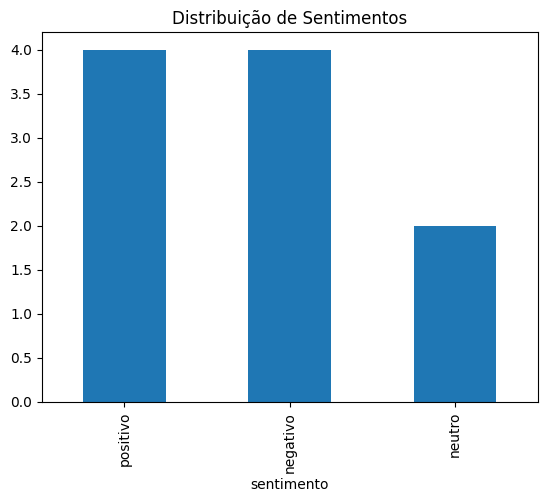

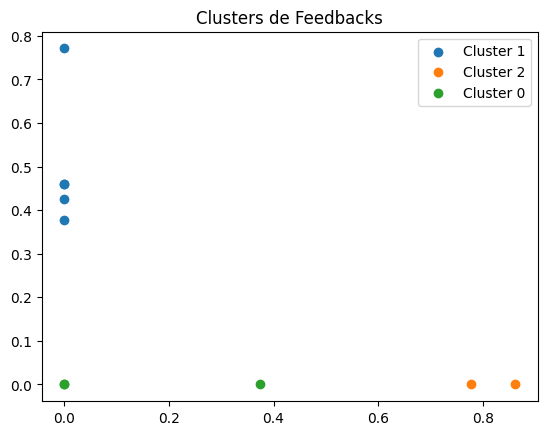

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans

# -----------------------------
# LDA – Tópicos
# -----------------------------
count_vec = CountVectorizer()
X_count = count_vec.fit_transform(df["texto_limpo"])

lda = LatentDirichletAllocation(n_components=3, random_state=42)
lda.fit(X_count)

print("Tópicos identificados:")
for i, topic in enumerate(lda.components_):
    palavras = [count_vec.get_feature_names_out()[j] for j in topic.argsort()[-6:]]
    print(f"Tópico {i}: {', '.join(palavras)}")

# -----------------------------
# Clustering
# -----------------------------
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
df["cluster"] = kmeans.fit_predict(X_svd)

# -----------------------------
# Gráficos
# -----------------------------
plt.figure()
df["sentimento"].value_counts().plot(kind="bar", title="Distribuição de Sentimentos")
plt.show()

plt.figure()
for c in df["cluster"].unique():
    idx = df["cluster"] == c
    plt.scatter(X_svd[idx, 0], X_svd[idx, 1], label=f"Cluster {c}")
plt.legend()
plt.title("Clusters de Feedbacks")
plt.show()
